In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [148]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [149]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [150]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [152]:
#data.DCOILBRENTEU.to_numericd
#data.GOLDPMGBD228NLBM = data.GOLDPMGBD228NLBM.astype(dtype = np.float64)
#data['GOLDPMGBD228NLBM'][0]
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [153]:
btc_trace = go.Scatter(x=data.index, y=data['exukus'], name= 'exu')
py.iplot([btc_trace])

In [154]:
data['exukus'].replace(0, np.nan, inplace=True)
data['exukus'].fillna(method='ffill', inplace=True)

In [155]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [156]:
values = data['exukus'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
values

array([[0.5942],
       [0.5956],
       [0.5977],
       ...,
       [0.7825],
       [0.7708],
       [0.7713]], dtype=float32)

In [13]:
scaled

array([[0.34262943],
       [0.34661353],
       [0.3525896 ],
       ...,
       [0.8784859 ],
       [0.8451905 ],
       [0.8466134 ]], dtype=float32)

In [14]:
#split dataset into train and test, 70% train 30% test

In [157]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [158]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [159]:
look_back = 3 #use 3 previous days to predict the next day
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

5548
2377


In [160]:
trainX

array([[0.34262943, 0.34661353, 0.3525896 ],
       [0.34661353, 0.3525896 , 0.39328384],
       [0.3525896 , 0.39328384, 0.41605008],
       ...,
       [0.52105856, 0.51052916, 0.4874786 ],
       [0.51052916, 0.4874786 , 0.46784282],
       [0.4874786 , 0.46784282, 0.45702899]], dtype=float32)

In [161]:
trainY

array([0.39328384, 0.41605008, 0.40239036, ..., 0.46784282, 0.45702899,
       0.44223094], dtype=float32)

In [162]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [143]:
trainX

array([[[0.34262943, 0.34661353, 0.3525896 ]],

       [[0.34661353, 0.3525896 , 0.39328384]],

       [[0.3525896 , 0.39328384, 0.41605008]],

       ...,

       [[0.52105856, 0.51052916, 0.4874786 ]],

       [[0.51052916, 0.4874786 , 0.46784282]],

       [[0.4874786 , 0.46784282, 0.45702899]]], dtype=float32)

In [163]:
#run the model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 5548 samples, validate on 2377 samples
Epoch 1/50
5548/5548 [==============================] - 2s 281us/step - loss: 0.1701 - val_loss: 0.0426
Epoch 2/50
5548/5548 [==============================] - 0s 72us/step - loss: 0.0523 - val_loss: 0.0565
Epoch 3/50
5548/5548 [==============================] - 0s 73us/step - loss: 0.0292 - val_loss: 0.0574
Epoch 4/50
5548/5548 [==============================] - 0s 71us/step - loss: 0.0146 - val_loss: 0.0543
Epoch 5/50
5548/5548 [==============================] - 0s 74us/step - loss: 0.0135 - val_loss: 0.0200
Epoch 6/50
5548/5548 [==============================] - 0s 73us/step - loss: 0.0121 - val_loss: 0.0184
Epoch 7/50
5548/5548 [==============================] - 0s 69us/step - loss: 0.0123 - val_loss: 0.0172
Epoch 8/50
5548/5548 [==============================] - 0s 70us/step - loss: 0.0119 - val_loss: 0.0170
Epoch 9/50
5548/5548 [==============================] - 0s 70us/step - loss: 0.0121 - val_loss: 0.0178
Epoch 10/50
5548/5548 [=

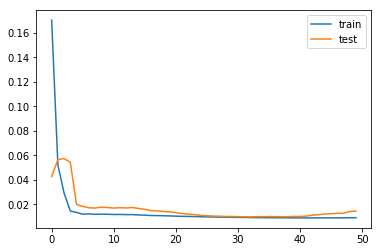

In [164]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

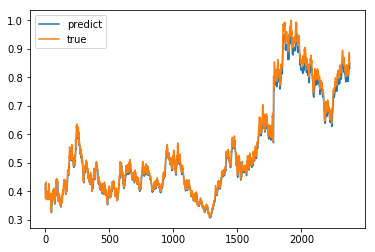

In [165]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [166]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [167]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.007


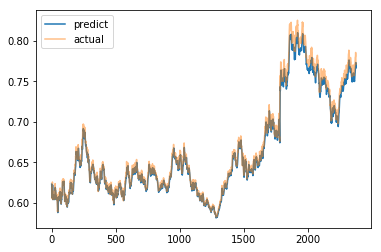

In [168]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [169]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [91]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

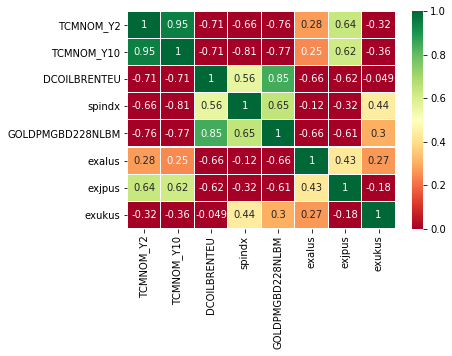

In [95]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [170]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [171]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [172]:
values = data[['exukus'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10']].values
number_of_variables = 3
#values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [173]:
#normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [175]:
#convert data to become supervised 
look_back = 1
time_steps = 2
reframed = series_to_supervised(scaled, look_back, time_steps)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t),var1(t+1),var2(t+1),var3(t+1)
1,0.342629,0.808402,0.852144,0.346614,0.809426,0.846501,0.352590,0.800205,0.836343
2,0.346614,0.809426,0.846501,0.352590,0.800205,0.836343,0.393284,0.781762,0.810384
3,0.352590,0.800205,0.836343,0.393284,0.781762,0.810384,0.416050,0.786885,0.816027
4,0.393284,0.781762,0.810384,0.416050,0.786885,0.816027,0.402390,0.783811,0.811512
5,0.416050,0.786885,0.816027,0.402390,0.783811,0.811512,0.398122,0.771516,0.803612


In [176]:
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[-7:], axis=1, inplace=True)
#reframed.drop(reframed.columns[-1 * number_of_variables + 1:], axis=1, inplace=True)
reframed.drop(reframed.columns[-2:], axis=1, inplace=True)
print(reframed.head())
#splitting data 
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)  var1(t+1)
1   0.342629   0.808402   0.852144  0.346614  0.809426  0.846501   0.352590
2   0.346614   0.809426   0.846501  0.352590  0.800205  0.836343   0.393284
3   0.352590   0.800205   0.836343  0.393284  0.781762  0.810384   0.416050
4   0.393284   0.781762   0.810384  0.416050  0.786885  0.816027   0.402390
5   0.416050   0.786885   0.816027  0.402390  0.783811  0.811512   0.398122


In [198]:
# split into input and outputs
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]


target = -1 * number_of_variables
look_back = 1
number_of_variables = 3
train_X, train_y = train[:, :(look_back * number_of_variables)], train[:, -1]
test_X, test_y = test[:, :(look_back * number_of_variables) ], test[:, -1]

In [178]:
train_X

array([[0.34262943, 0.80840164, 0.8521445 ],
       [0.34661353, 0.80942625, 0.8465011 ],
       [0.3525896 , 0.8002049 , 0.83634305],
       ...,
       [0.4874786 , 0.07684426, 0.21218963],
       [0.46784282, 0.0727459 , 0.20541762],
       [0.45702899, 0.07479508, 0.22347628]], dtype=float32)

In [179]:
train_y

array([0.3525896 , 0.39328384, 0.41605008, ..., 0.45702899, 0.44223094,
       0.43710864], dtype=float32)

In [199]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5550, 1, 3) (5550,) (2379, 1, 3) (2379,)


In [200]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 5550 samples, validate on 2379 samples
Epoch 1/50
5550/5550 [==============================] - 2s 346us/step - loss: 0.2007 - val_loss: 0.1951
Epoch 2/50
5550/5550 [==============================] - 0s 81us/step - loss: 0.1467 - val_loss: 0.1617
Epoch 3/50
5550/5550 [==============================] - 0s 80us/step - loss: 0.1327 - val_loss: 0.1243
Epoch 4/50
5550/5550 [==============================] - 0s 80us/step - loss: 0.1182 - val_loss: 0.0993
Epoch 5/50
5550/5550 [==============================] - 0s 79us/step - loss: 0.1053 - val_loss: 0.0746
Epoch 6/50
5550/5550 [==============================] - 0s 74us/step - loss: 0.0917 - val_loss: 0.0542
Epoch 7/50
5550/5550 [==============================] - 0s 68us/step - loss: 0.0680 - val_loss: 0.0502
Epoch 8/50
5550/5550 [==============================] - 0s 67us/step - loss: 0.0378 - val_loss: 0.0732
Epoch 9/50
5550/5550 [==============================] - 0s 69us/step - loss: 0.0324 - val_loss: 0.0457
Epoch 10/50
5550/5550 [=

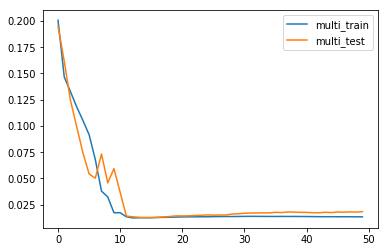

In [201]:
#plot result 
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

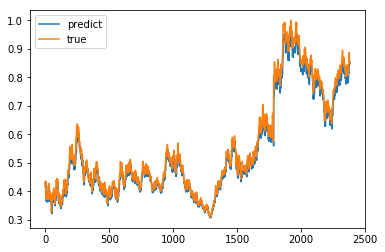

In [202]:
#plot prediction
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [203]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#test_X.shape[2]

In [204]:
test_X

array([[0.44223094, 0.07786885, 0.23476298],
       [0.43710864, 0.0819672 , 0.24040632],
       [0.42287982, 0.0819672 , 0.26410836],
       ...,
       [0.87364817, 0.27151638, 0.19300224],
       [0.8870232 , 0.27459013, 0.1975169 ],
       [0.8784859 , 0.27766392, 0.20090295]], dtype=float32)

In [205]:
#test_X[:, 1:]
yhat

array([[0.43053925],
       [0.42558804],
       [0.4116052 ],
       ...,
       [0.84451187],
       [0.85727084],
       [0.8491852 ]], dtype=float32)

In [206]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

In [207]:
inv_yhat

array([[0.43053925, 0.07786885, 0.23476298],
       [0.42558804, 0.0819672 , 0.24040632],
       [0.4116052 , 0.0819672 , 0.26410836],
       ...,
       [0.84451187, 0.27151638, 0.19300224],
       [0.85727084, 0.27459013, 0.1975169 ],
       [0.8491852 , 0.27766392, 0.20090295]], dtype=float32)

In [208]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [209]:
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [210]:
inv_yhat

array([0.6934572 , 0.69284576, 0.6911192 , ..., 0.74457544, 0.7461508 ,
       0.7451524 ], dtype=float32)

In [212]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)

In [213]:
inv_y

array([[0.42287982, 0.07786885, 0.23476298],
       [0.43511653, 0.0819672 , 0.24040632],
       [0.4126351 , 0.0819672 , 0.26410836],
       ...,
       [0.8784859 , 0.27151638, 0.19300224],
       [0.8451905 , 0.27459013, 0.1975169 ],
       [0.8466134 , 0.27766392, 0.20090295]], dtype=float32)

In [214]:
inv_y = scaler.inverse_transform(inv_y)

In [215]:
inv_y

array([[0.6224    , 0.91999996, 3.45      ],
       [0.6267    , 0.9599999 , 3.5       ],
       [0.6188    , 0.9599999 , 3.7100003 ],
       ...,
       [0.78249997, 2.8100002 , 3.08      ],
       [0.7708    , 2.84      , 3.12      ],
       [0.77129996, 2.8700001 , 3.15      ]], dtype=float32)

In [217]:
inv_y = inv_y[:,0]

In [218]:
inv_y

array([0.6224    , 0.6267    , 0.6188    , ..., 0.78249997, 0.7708    ,
       0.77129996], dtype=float32)

In [219]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.057


In [192]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])